### Hi, we are Tamas Spisak, Balint Kincses and Robert Englert from the Laboratory of Predictive Neuroimaging UK Essen (Germany). First of all, let us thank the organizers for this most exciting Kaggle competition. This was our first ever Kaggle competition and we landed 9th (0.15681) on the public and 13th (0.15753) on the private leaderboard! 
### Let us start with a bit of "advertisement": We are currently expanding our research group, so if you are interested in persuing a careeer in Neuroscience/Neuroimaging by applying techniques of Machine Learning, click here: https://pni-lab.github.io/blog/postdoc_and_phd_student_job_advert/
### What better place to advertise, than on a Kaggle competition with Neuroscience Data? ;)

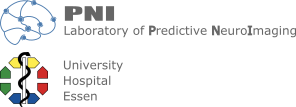

# Our approach in a nutshell:

We were essentially using an ensemble with a low-key hyperparameter optimization, with - most probably - a lot of space for improvement...
We were more interested in feature engeneering, especially for the functional connectivity data and actually, a novel, dynamic recurrent neural network-based feature transformation approach catapulted us from place ~50 to place 8, without changing anything else. See some more details below, in the notebook.

Some other approaches which were included in the final model:
- we trained a site classifier and regressed out its predictions form all fetures.
- some fnc transformations taking advantage of the modular nature of the data:
    - internal and external connectivities within the resting-state networks (RSNs)
    - connectivity across RSNs
- fnc graph-theoretical parameters (node degree, clusteredness, various centralities)
- brain atlas based mean activations and globally computed percentiles from the spatial maps
- hemispherical assymetry indices computed from the spatial maps (not used in final model).
- to account for (or take use of!) potential imaging artifacts, we extracted white-matter and cerebrospinal-fluid signal from these maps, too.
- we also applied some more traditional feature transfromations, e.g. often added the quadratic terms, as U-shaped (or inverse U-shaped) relationships are often found with age. We also often slightly winsorized the data to mitigate the effect of potential outliers.



# Let's start with the notebook!

## Just some imports

In [ ]:
import numpy as np
import pandas as pd
import json
import warnings
#from cuml.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, RidgeCV, OrthogonalMatchingPursuit
from sklearn.svm import SVR
import scipy
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import Parallel, delayed, load, dump

def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

# turn cell width to 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

base_path = '/kaggle/input/trends-assessment-prediction/'
feature_path = '/kaggle/input/pni-trends-features/'

# Here we load all the features from the attached dataset
Some of the features required a lot of compoutations, so we computed those on local machines.
Below some details about each.
- site_prediction: While we do not detail the classification model here, it was eseentially a simple RidgeClassifier with some manual calibration.
- fnc_graph_params: Node-level graph-theoretical parameters from the fnc data as calculated by networkx.
- csf_features: mean "activity" in cerebrospinal fluid regions per IC
- wm_features: mean activity in white matter, per IC
- gm_all_features and gm_max_features: mean activity values, extracted from the 122-region version of the BASC-atlas (nilearn)
- asym_winsorized_features: assymetry indeces, computed on the voxel-level and then averaged across activated voxels.

- PNI_features: our secret weapon, a recurrent neural network-based transformation of the functional connectivity matrix, which embeds both connectivity strength and complex network structure into a smaller dataset. This boosted our predictive accuracy significantly! The manuscript describing the approach is currently in prep, but we are happy to share some details upon reasonable request.

All the algorithms producing the other features are also available upon request.

In [ ]:
# we did a site 1 vs site 2 classification (TPrate 86%) to later regress out the sitedifferences in our features
prediction_pooled = pd.read_csv(feature_path + "site_prediction.csv").drop('Unnamed: 0', axis=1)
graphparams = pd.read_csv(feature_path + 'fnc_graph_params.csv')
# we extracted the Cerebral Spinal Fluid, White Matter and Gray Matter from the spatial maps 
csf_df = pd.read_csv(feature_path + 'csf_features')
wm_df = pd.read_csv(feature_path + 'wm_features')
gm_all_df = pd.read_csv(feature_path + 'gm_all_features')
gm_df = pd.read_csv(feature_path + 'gm_max_features')
# the PNI features are a new set of features that are currently in the works for a publication
pni_df = pd.read_csv(feature_path + 'PNI_features')
loading_df = pd.read_csv(base_path +"loading.csv")
# The assymetry between the two hemispheres is a good predictor for age
# the assymetry was clipped at zero and winsorized for better performance
asym_df = pd.read_csv(feature_path +  'asym_winsorized_features')

## Here we compute the RSN-based network transformations

In [ ]:
# the naming of the fnc features indicate that they are based off from large scale resting state networks
# the internal and external connectivity between the regions are therefore extracted as new features

fnc_data = pd.read_csv(base_path + 'fnc.csv')
"""
SCN - Sub-cortical Network
ADN - Auditory Network
SMN - Sensorimotor Network
VSN - Visual Network
CON - Cognitive-control Network
DMN - Default-mode Network
CBN - Cerebellar Network
"""

networks = np.array(['SCN', 'ADN', 'SMN', 'VSN', 'CON', 'DMN', 'CBN'])
internal_conn = np.zeros((len(fnc_data.Id), len(networks)))
external_conn = np.zeros((len(fnc_data.Id), len(networks)))

netmat = pd.DataFrame({'Id': fnc_data.Id})
netmat_count = pd.DataFrame({'Id': [int(1)]})

internal_count = np.zeros(len(networks))
external_count = np.zeros(len(networks))

for c in fnc_data.drop('Id', axis=1).columns:
    #print(c)
    splitted=c.split('_')
    #print(splitted[0][:3], splitted[2][:3])
    netmat_col=splitted[0][:3] + '_vs_' + splitted[2][:3]
     
    if netmat_col not in netmat:
        netmat[netmat_col]=fnc_data[c].values
        netmat_count[netmat_col]=1
    else:
        netmat[netmat_col]+=fnc_data[c].values
        netmat_count[netmat_col]+=1
        
    ########### internal - external
    
    if splitted[0][:3] == splitted[2][:3]:
        #print("within", np.argwhere(networks==splitted[0][:3])[0])
        whichnetwork = np.argwhere(networks==splitted[0][:3])[0][0]
        internal_conn[:,whichnetwork] += fnc_data[c].values
        internal_count[whichnetwork] += 1
    else:
        #print("between", np.argwhere(networks==splitted[0][:3])[0] , np.argwhere(networks==splitted[2][:3])[0] )
        whichnetwork1 = np.argwhere(networks==splitted[0][:3])[0][0]                 
        external_conn[:,whichnetwork1] += fnc_data[c].values
        whichnetwork2 = np.argwhere(networks==splitted[2][:3])[0][0]                
        external_conn[:,whichnetwork2] += fnc_data[c].values
        
        external_count[whichnetwork1] += 1
        external_count[whichnetwork2] += 1

# normalize netmat
netmat /= netmat_count.values
netmat = pd.DataFrame(netmat)

# normalise
internal_conn /= internal_count 
external_conn /= external_count 
                         
internal_conn = pd.DataFrame(internal_conn, columns=[ "int_" + str(c) for c in networks])
internal_conn.insert(0, 'Id', fnc_data.Id)
external_conn = pd.DataFrame(external_conn, columns=[ "ext_" + str(c) for c in networks]) 
external_conn.insert(0, 'Id', fnc_data.Id)


# div
internal_conn_tmp = internal_conn.copy()
external_conn_tmp = external_conn.copy()
external_conn_tmp.columns = internal_conn_tmp.columns = ['Id'] + ["div_" + str(c) for c in networks]
intdivext = internal_conn_tmp/external_conn_tmp
intdivext.Id=internal_conn.Id

# mult (interaction)
external_conn_tmp.columns = internal_conn_tmp.columns = ['Id'] + ["mult_" + str(c) for c in networks]
intmultext = internal_conn_tmp*external_conn_tmp
intmultext.Id=internal_conn.Id



Just some data consolidation below:

In [ ]:
fnc=fnc_data

fnc_feat_vecs = fnc.iloc[:, 1:].values
fnc_feat_vecs.shape
icn_numbers = pd.read_csv(base_path + "ICN_numbers.csv")
icn_numbers["FNC_name"] = ["SCN(69)"] + list(map(lambda x: x.split("_")[0], fnc.columns[1:53]))
col_labels = icn_numbers["FNC_name"].values

degree=pd.DataFrame(np.zeros((fnc_feat_vecs.shape[0], len(col_labels))), columns=['degree_' + c for c in col_labels])
clustering_r=pd.DataFrame(np.zeros((fnc_feat_vecs.shape[0], len(col_labels))), columns=['clusteringr_' + c for c in col_labels])
clustering_i=pd.DataFrame(np.zeros((fnc_feat_vecs.shape[0], len(col_labels))), columns=['clusteringi_' + c for c in col_labels])
betweenness_centrality=pd.DataFrame(np.zeros((fnc_feat_vecs.shape[0], len(col_labels))), columns=['between_' + c for c in col_labels])
eigenvector_centrality=pd.DataFrame(np.zeros((fnc_feat_vecs.shape[0], len(col_labels))), columns=['eigenvec_' + c for c in col_labels])


Getting column names to easily address feature types later.

In [ ]:
# get colnames for each feature group 
col_loading_features = list(loading_df.columns[1:])
col_fnc_features = list(fnc_data.columns[1:])
col_netmat_features = list(netmat.columns[1:])
col_internalconn_features = list(internal_conn.columns[1:])
col_externalconn_features = list(external_conn.columns[1:])
col_intmultext_features = list(intmultext.columns[1:])
col_gm_features = list(gm_df.columns[1:])
col_wm_features = list(wm_df.columns[1:])
col_csf_features = list(csf_df.columns[1:])  
col_gm_all = list(gm_all_df.columns[1:])  
col_pni = list(pni_df.columns[1:])
col_asym_features = list(asym_df.columns[1:]) 
col_graphparams_features = list(graphparams.columns[1:]) 
col_degree_features = list(degree)    
col_clustering_features = list(clustering_r) + list(clustering_i)
col_clustering_r_features = list(clustering_r) 
col_clustering_i_features = list(clustering_i) 
col_betweenness_centrality_features = list(betweenness_centrality)
col_eigenvector_centrality_features = list(eigenvector_centrality)

# merge dataframes
df = loading_df.merge(fnc_data, on="Id").merge(netmat, on="Id").merge(internal_conn, on="Id").merge(external_conn, on="Id").merge(intmultext, on='Id').merge(gm_df, on="Id").merge(wm_df, on="Id").merge(csf_df, on="Id").merge(pni_df, on='Id').merge(asym_df, on='Id').merge(graphparams, on='Id')


# Here we regress out the predicted site affect from all features.

In [ ]:
# regressing out the site effects
from sklearn.linear_model import LinearRegression
df_pandas = df.copy()
tmp_df=prediction_pooled.merge(df_pandas, on='Id')
for c in tmp_df.columns:
    if c=='Id' or c=='site_predicted_fixed' or c=='site_predicted' or c=='predicted':
        continue
    model = LinearRegression()
    model.fit(tmp_df.site_predicted_fixed.values.reshape(-1,1), tmp_df[c].values)
    prediction = model.predict(tmp_df.site_predicted_fixed.values.reshape(-1,1))
    df_pandas.at[:,c] = (df_pandas[c] - prediction)
df_sitereg = pd.DataFrame(df_pandas)

df_sitereg = df_sitereg.merge(gm_all_df , on = 'Id')

labels_df = pd.read_csv(base_path + "train_scores.csv")
labels_df["is_train"] = True

df = df_sitereg.merge(labels_df, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

# Optimal Parameters for the different Pipelines

Optimal hyperparameters were computed locally for each model. 
As mentioned above, we performed a low-key optimization. We are sure a more comprehensive optimization could still considerably imporve the final model performance.

Below you will see the "optimal" hyperparameters for each model simply stored in a map.
Then we define some helper functions, to be used in scikitlearn pipelines.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# optimal parameters for each pipeline were obtained with the RandomizedSearchCV of sklearn

with open(feature_path + 'optpars.json', 'r') as fp:
    optpars = json.load(fp)

def down_scale(x, factor):
    return x*factor

def square(x):
    return x*x


def winsorize(x, l=0.0001, h=0.0001):
    return scipy.stats.mstats.winsorize(x, (l, h))

# Model

Here's the ensemble itself. No magic here, mainly ridges (and some SVMs) for various subsets of the fetures and a bit of bagging now-and-than.
Note that this part wasn't systematically optimised (as we were primarly interested in the performance of our new fearures, rather than the ML-part).

In [ ]:
test_result=test_df.copy()

reg = dict()

features = col_loading_features+col_fnc_features+col_netmat_features+col_internalconn_features+col_externalconn_features+col_intmultext_features+col_gm_features+col_wm_features+col_csf_features+col_asym_features+col_graphparams_features+col_gm_all+col_pni


for target in ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']:
    print("*****",target)
    
    dfnona = df[df[target].notnull()]

    estimators = [
        #0 ##################################################
        ('sbm+funcdeweighted_win_ridge',
        Pipeline([('columns', ColumnTransformer([
                                        ('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                            ('fnc', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_fnc_features),
                                            ('internal_conn', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_internalconn_features),
                                            ('external_conn', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_externalconn_features),
                                            ('intmultext', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_intmultext_features),
                                          ],remainder='drop')),
            ('win', FunctionTransformer(winsorize, kw_args={'l': 0.0001, 'h': 0.0001}, validate=True)),
            ('e', Ridge(alpha=optpars['sbm+funcdeweighted_win_ridge'][target]))
        ])),
        #1 ##################################################
        ('sbm+funcdeweighted_win_ridgebag',
        Pipeline([('columns', ColumnTransformer([
                                            ('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                            ('fnc', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_fnc_features),
                                            ('gm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_gm_features),
                                            ('gm2', FunctionTransformer(square, validate=True), col_gm_features),
                                            ('wm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_wm_features),
                                            ('wm2', FunctionTransformer(square, validate=True), col_wm_features),
                                            ('csf', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_csf_features),
                                            ('csf2', FunctionTransformer(square, validate=True), col_csf_features),
                                          ],remainder='drop')),
            ('win', FunctionTransformer(winsorize, kw_args={'l': 0.0001, 'h': 0.0001}, validate=True)),
            ('e', BaggingRegressor(Ridge(alpha=optpars['sbm+funcdeweighted_win_ridgebag'][target]),
                                                  n_estimators=20,
                                                  random_state=42,
                                                  max_samples=0.8,
                                                  max_features=0.8))
        ])),
        #2 ##################################################
        ('sbm+sbm_win_ridge',
        Pipeline([('columns', ColumnTransformer([('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                         ('sbm2', FunctionTransformer(square, validate=True), col_loading_features)
                                         ],remainder='drop')),
            ('win', FunctionTransformer(winsorize, kw_args={'l': 0.0001, 'h': 0.0001}, validate=True)),
            ('e', Ridge(alpha=optpars['sbm+sbm_win_ridge_alpha'][target]))
        ])),
        #3 ##################################################
        ('sbm+sbm_win_ridgebag',
        Pipeline([('columns', ColumnTransformer([('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                         ('sbm2', FunctionTransformer(square, validate=True), col_loading_features)
                                         ],remainder='drop')),
            ('win', FunctionTransformer(winsorize, kw_args={'l': 0.0001, 'h': 0.0001}, validate=True)),
            ('e', BaggingRegressor(Ridge(alpha=optpars['sbm+sbm_win_ridge_alphabag'][target]),
                                                  n_estimators=20,
                                                  random_state=42,
                                                  max_samples=0.8,
                                                  max_features=0.8))
        ])),
        #4 ##################################################
        ('fnc_extended_ridge', Pipeline([
            ('columns', ColumnTransformer([('fnc', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_fnc_features),
                                           ('internal_conn', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_internalconn_features),
                                           ('external_conn', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_externalconn_features),
                                           ('intmultext', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_intmultext_features),
                                           ('netmat', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_netmat_features),
                                           ('netmat2', FunctionTransformer(square, validate=True), col_netmat_features)
                                          ],
                                           remainder='drop')),
            ('win', FunctionTransformer(winsorize, validate=True)),
            ('e', Ridge(alpha=optpars['fnc_extended_ridge'][target]))
        ])),
        #5 ##################################################
        ('fnc_extended_ridgebag', Pipeline([
            ('columns', ColumnTransformer([('fnc', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_fnc_features),
                                           ('internal_conn', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_internalconn_features),
                                           ('external_conn', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_externalconn_features),
                                           ('intmultext', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_intmultext_features),
                                           ('netmat', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_netmat_features),
                                           ('netmat2', FunctionTransformer(square, validate=True), col_netmat_features)
                                          ],
                                           remainder='drop')),
            ('win', FunctionTransformer(winsorize, validate=True)),
            ('e', BaggingRegressor(Ridge(alpha=optpars['fnc_extended_ridgebag'][target]),
                                                  n_estimators=20,
                                                  random_state=42,
                                                  max_samples=0.8,
                                                  max_features=0.8))
        ])),
        #6 ##################################################
        ('fnc_simple_ridge', Pipeline([
            ('columns', ColumnTransformer([('internal_conn', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_internalconn_features),
                                            ('external_conn', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_externalconn_features),
                                            ('netmat', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_netmat_features)
                                            
                                          ],
                                           remainder='drop')),
            ('win', FunctionTransformer(winsorize, validate=True)),
            ('poly', PolynomialFeatures()),
            ('e', Ridge(alpha=optpars['fnc_simple_ridge'][target]))
        ])),
        #7 ##################################################
        ('spatial_maps_gmmax_wm_csf', Pipeline([
            ('columns', ColumnTransformer([('gm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_gm_features),
                                            ('gm2', FunctionTransformer(square, validate=True), col_gm_features),
                                            ('wm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_wm_features),
                                            ('wm2', FunctionTransformer(square, validate=True), col_wm_features),
                                            ('csf', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_csf_features),
                                            ('csf2', FunctionTransformer(square, validate=True), col_csf_features)                             
                                          ],
                                           remainder='drop')),
            ('win', FunctionTransformer(winsorize, validate=True)),
            ('e', Ridge(alpha=optpars['spatial_maps_gmmax_wm_csf'][target]))
        ])),
        #8 ##################################################
        ('sbm+funcdeweighted_win_svr',
        Pipeline([('columns', ColumnTransformer([
                                            ('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                            ('fnc', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_fnc_features),
                                            ('internal_conn', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_internalconn_features),
                                            ('external_conn', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_externalconn_features),
                                            ('intmultext', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_intmultext_features)
                                          ],remainder='drop')),
            ('win', FunctionTransformer(winsorize, kw_args={'l': 0.0001, 'h': 0.0001}, validate=True)),
            ('e', SVR(C=optpars['sbm+funcdeweighted_win_svr'][target], cache_size=1000, gamma='scale'))
        ])),

        # 9 ##############################
        ('fnc_graph_ridge_alpha',
        Pipeline([
            ('columns', ColumnTransformer([('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                            ('fnc', FunctionTransformer(down_scale, kw_args={'factor': 1/600}, validate=True), col_fnc_features),
                ('degree', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_degree_scale'][target]}, validate=True), col_degree_features),
                ('clustering_r', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_clustering_r_scale'][target]}, validate=True), col_clustering_r_features),
                ('clustering_i', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_clustering_i_scale'][target]}, validate=True), col_clustering_i_features),
                ('betweenness', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_betweenness_scale'][target]}, validate=True), col_betweenness_centrality_features),  
                ('eigenvec', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_eigenvec_scale'][target]}, validate=True), col_eigenvector_centrality_features),
                ('gm', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_gm_scale'][target]}, validate=True), col_gm_features),
                ('csf', FunctionTransformer(down_scale, kw_args={'factor': optpars['fnc_graph_ridge_csf_scale'][target]}, validate=True), col_csf_features),
                           
                                                              ],
                                           remainder='drop')),
            ('var', VarianceThreshold(0)),
            ('e', Ridge(alpha=optpars['fnc_graph_ridge_alpha'][target]))
        ])),
        # 10 #######################
        ('gm_all_ridge',
        Pipeline([
            ('columns', ColumnTransformer([ ('wm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_wm_features),
                                            ('wm2', FunctionTransformer(square, validate=True), col_wm_features),
                                            ('csf', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_csf_features),
                                            ('csf2', FunctionTransformer(square, validate=True), col_csf_features),
                                            ('gm_all', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_gm_all)                              
                                          ],
                                           remainder='drop')),
            ('win', FunctionTransformer(winsorize, validate=True)),
            ('e', Ridge(alpha=optpars['gm_all_ridge_alpha'][target]))
        ])),
        
        # 11 ################################
        # base PNI
        ('sbm_PNI_ridge',
        Pipeline([('columns', ColumnTransformer([
                                        ('sbm', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_loading_features),
                                        ('PNI', FunctionTransformer(down_scale, kw_args={'factor': 1}, validate=True), col_pni)
                                          ],remainder='drop')),
            ('e', Ridge(alpha=optpars['sbm_PNI_ridge_alpha'][target]))
        ])),
        
    ]
    
    #drop some estimators:
    if target=='domain1_var1' or target=='domain2_var2':
        estimators = estimators[2:] # no ridge with sbm+fnc/600
    
    print([e[0] for e in estimators])
        

    from sklearn.ensemble import StackingRegressor
    reg[target] = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(alphas=[500, 1000, 5000, 10000]), passthrough=False, verbose=0, cv=6, n_jobs=1)
    reg[target].fit(dfnona[features], dfnona[target].values)
    
    #####################################################
    print(metric(reg[target].predict(dfnona[features]), dfnona[target].values))
    # note that this below is suboptimal in terms of computatioin time:
    cv_score = cross_val_score(reg[target],
                                 dfnona[features],
                                 dfnona[target].values,
                                 scoring=make_scorer(metric, greater_is_better=False))
    print(np.mean(cv_score), cv_score)
    test_result[target] = reg[target].predict(test_result[features])

In [ ]:
sub_df = pd.melt(test_result[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.to_csv("submission.csv", index=False)
sub_df.head(10)

And that's all. The variable "test_result" was simply melted and submitted.
This submission scores 0.15681 on the public and 0.15753 on the private leaderboard.
We are looking forward to see the site-2 leaderboard results!

# We are thankful to the organizers for this most exciting competition!

Dr. Tamas Spisak, PhD

Robert Englert, Msc

Balint Kincses, MD, PhD

Laboratory of Predictive Neuroimaging
Institute for Artificial Intelligence in Medicine
Institute for Diagnostic and Interventional Radiology and Neuroradiology
University Hospital Essen

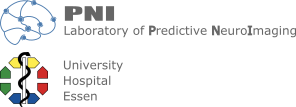

https://pni-lab.github.io/

